# Kick

URL : https://www.openml.org/d/41162

- One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".
- Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.
- Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

*The challenge of this competition is to predict if the car purchased at the Auction is a Kick (bad buy).*

Number of Instances: **72983**

Attribute Characteristics: **numeric, categorical**

Number of Attributes: **33**

Missing Values: **149271**

Target variable: **IsBadBuy**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import KFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
kick_data = pd.read_csv("kick.csv", sep=',')

In [3]:
kick_data.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155,9829,11636,13600,7451,8552,11597,12409,?,?,21973,33619,FL,7100,0,1113
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854,8383,10897,12572,7456,9222,11374,12791,?,?,19638,33619,FL,7600,0,1053
2,0,1260144000,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202,4760,6943,8457,4035,5557,7146,8702,?,?,19638,33619,FL,4900,0,1389
3,0,1260144000,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893,2675,4658,5690,1844,2646,4375,5518,?,?,19638,33619,FL,4100,0,630
4,0,1260144000,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2,Covers,69367,AMERICAN,COMPACT,FORD,3913,5054,7723,8707,3247,4384,6739,7911,?,?,19638,33619,FL,4000,0,1020


In [4]:
kick_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   IsBadBuy                           72983 non-null  int64 
 1   PurchDate                          72983 non-null  int64 
 2   Auction                            72983 non-null  object
 3   VehYear                            72983 non-null  int64 
 4   VehicleAge                         72983 non-null  int64 
 5   Make                               72983 non-null  object
 6   Model                              72983 non-null  object
 7   Trim                               72983 non-null  object
 8   SubModel                           72983 non-null  object
 9   Color                              72983 non-null  object
 10  Transmission                       72983 non-null  object
 11  WheelTypeID                        72983 non-null  object
 12  Whee

In [5]:
kick_data.describe(include="all")

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,7.298300e+04,72983,72983.000000,72983.000000,72983,72983,72983,72983,72983,72983,72983,72983,72983.000000,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983,72983.000000,72983.000000,72983,72983,72983.000000,72983.000000
unique,NaN,NaN,3,NaN,NaN,33,1063,135,864,17,4,5,4,NaN,5,13,5,10343,11380,12726,13457,10316,11266,12494,13193,3,3,NaN,NaN,37,2011,NaN,NaN
top,NaN,NaN,MANHEIM,NaN,NaN,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,1,Alloy,NaN,AMERICAN,MEDIUM,GM,0,0,0,0,0,0,0,0,?,?,NaN,NaN,TX,7500,NaN,NaN
freq,NaN,NaN,41043,NaN,NaN,17248,2329,13950,15236,14875,70398,36050,36050,NaN,61028,30785,25314,828,697,828,828,504,378,504,504,69564,69564,NaN,NaN,13596,777,NaN,NaN
mean,0.122988,1.263092e+09,NaN,2005.343052,4.176644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71499.995917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26345.842155,58043.059945,NaN,NaN,0.025280,1276.580985
std,0.328425,1.819602e+07,NaN,1.731252,1.712210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14578.913128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25717.351219,26151.640415,NaN,NaN,0.156975,598.846788
min,0.000000,1.231114e+09,NaN,2001.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4825.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,835.000000,2764.000000,NaN,NaN,0.000000,462.000000
25%,0.000000,1.248048e+09,NaN,2004.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61837.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17212.000000,32124.000000,NaN,NaN,0.000000,837.000000
50%,0.000000,1.264032e+09,NaN,2005.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73361.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19662.000000,73108.000000,NaN,NaN,0.000000,1155.000000
75%,0.000000,1.279066e+09,NaN,2007.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82436.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22808.000000,80022.000000,NaN,NaN,0.000000,1623.000000


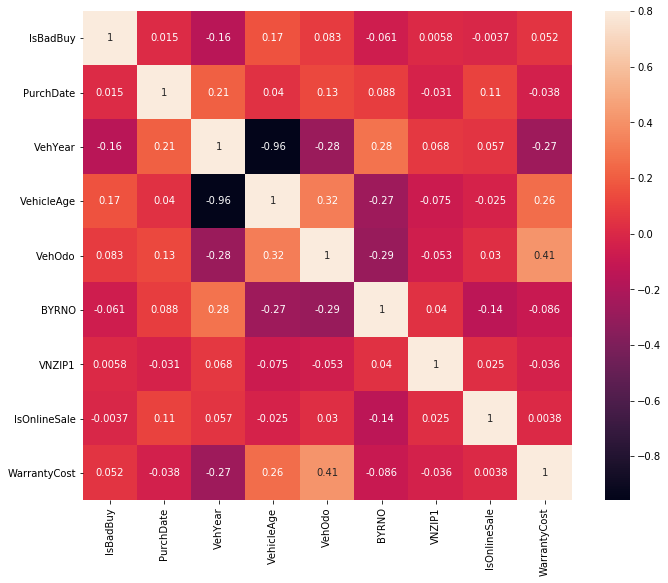

In [6]:
correlation_matrix = kick_data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, annot=True)
plt.show()

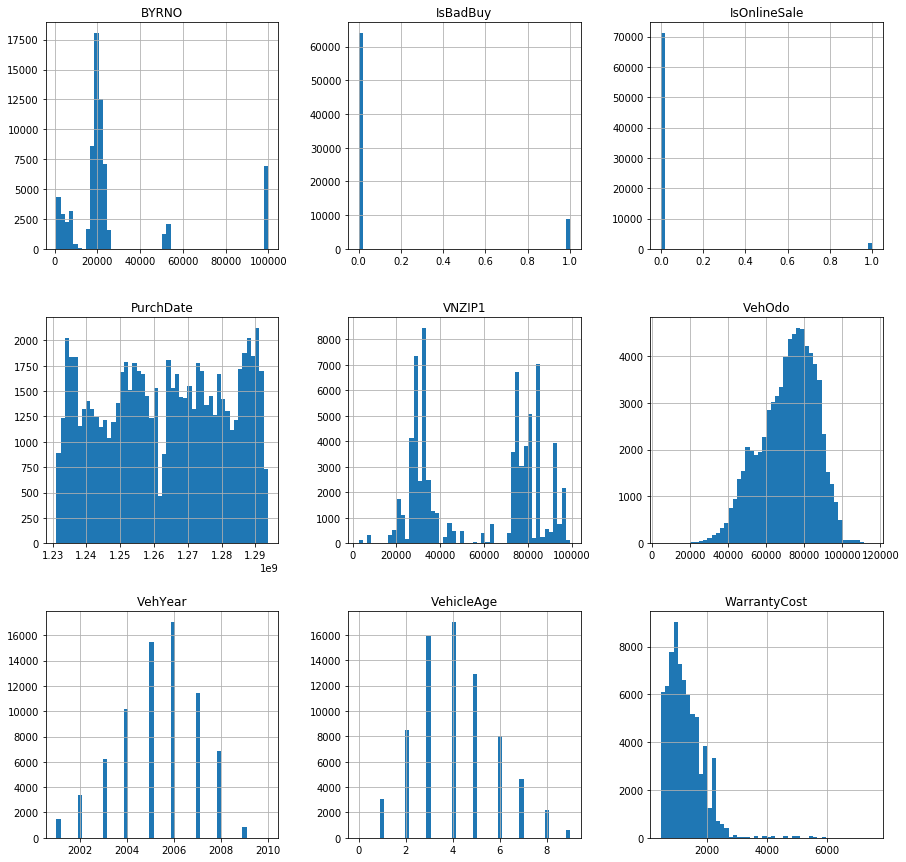

In [7]:
kick_data.hist(bins=50, figsize=(15,15))
plt.show()

From the plot we can see that our target attribute is very unbalanced because we have `~90%` of the data set as **0** and the rest to **1**. Also we see that people do not like to buy cars online. VehYear and VehicleAge seem highly correlated because they provide the same information

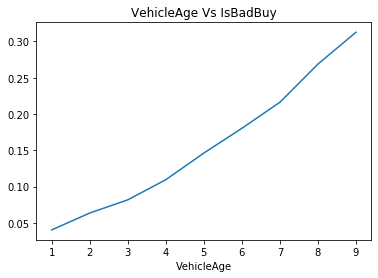

In [8]:
kick_data.groupby('VehicleAge').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot(title = "VehicleAge Vs IsBadBuy")
plt.show()

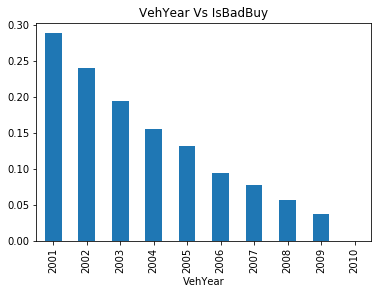

In [9]:
kick_data.groupby("VehYear").mean()["IsBadBuy"].plot.bar(title = "VehYear Vs IsBadBuy")
plt.show()

### Handling missing values

In [10]:
kick_data.replace('?', np.NaN, inplace=True)

print("Total number of missing values:", kick_data.isna().sum().sum())
display(kick_data.isna().sum())

Total number of missing values: 149271


IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentAuctionCleanPrice            315
MMRCurrentR

In [11]:
print("Total values:", kick_data['PRIMEUNIT'].count())
print("Missing values:", kick_data['PRIMEUNIT'].isna().sum())

display(kick_data['PRIMEUNIT'].value_counts().sort_values(ascending=False))

Total values: 3419
Missing values: 69564


NO     3357
YES      62
Name: PRIMEUNIT, dtype: int64

PRIMEUNIT feature has only **3419** values and the remaining **69564** are missing values. The value distribution is **3357 NO** and **62 YES**

In [12]:
print("Total values:", kick_data['AUCGUART'].count())
print("Missing values:", kick_data['AUCGUART'].isna().sum())

display(kick_data['AUCGUART'].value_counts().sort_values(ascending=False))

Total values: 3419
Missing values: 69564


GREEN    3340
RED        79
Name: AUCGUART, dtype: int64

AUCGUART feature has only **3419** values and the remaining **69564** are missing values. The value distribution is **3340 GREEN** and **79 RED**

Since around *95%* of the total values are missing, we will drop both attributes

In [13]:
kick_data.drop(['PRIMEUNIT', 'AUCGUART'], axis=1, inplace=True)

*WheelTypeID* and *WheelType* give us the same information, therefore we will drop *WheelType* and will keep *WheelTypeID* for further analysis.

In [14]:
kick_data['WheelTypeID'].value_counts()

1    36050
2    33004
3      755
0        5
Name: WheelTypeID, dtype: int64

In [15]:
kick_data.loc[kick_data['WheelTypeID'] == '0']

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
2992,0,1292544000,OTHER,2006,4,PONTIAC,G6 V6,Bas,4D SEDAN,BEIGE,AUTO,0,NaN,78098,AMERICAN,MEDIUM,GM,5529,6630,8841,10601,6700,8056,9831,10995,1141,48265,MI,7125,1,1272
3926,0,1277251200,OTHER,2008,2,DODGE,MAGNUM V6,SXT,WAGON 3.5L,GREY,AUTO,0,NaN,91501,AMERICAN,SPECIALTY,CHRYSLER,12714,14605,16664,18663,9824,11708,14366,15580,19638,35004,AL,8600,0,1630
42640,1,1287619200,MANHEIM,2001,9,CHRYSLER,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,0,NaN,74875,AMERICAN,MEDIUM,CHRYSLER,2692,3602,5942,7951,2535,3328,4494,5900,18880,29532,SC,5170,0,1689
47731,0,1288656000,MANHEIM,2006,4,VOLKSWAGEN,JETTA 5C,Bas,4D SEDAN,BEIGE,AUTO,0,NaN,70644,OTHER,SPECIALTY,OTHER,8030,9411,11663,13115,7752,8997,11257,12467,52492,75050,TX,8085,0,1272
69331,0,1276214400,ADESA,2007,3,CHRYSLER,PT CRUISER,Tou,4D SEDAN,SILVER,AUTO,0,NaN,69738,AMERICAN,MEDIUM,CHRYSLER,6149,7193,9945,10758,5389,6660,8893,10169,1151,91752,CA,6230,1,1215


We see that for 5 rows, when *WheelTypeID* is **0**, *WheelType* is **NaN** therefore, we will set `WheelTypeID=0` whenever `WheelType=NaN`

In [16]:
kick_data.loc[kick_data['WheelType'].isna(), 'WheelTypeID'] = 0
kick_data['WheelTypeID'] = kick_data['WheelTypeID'].astype(int)

# Drop WheelType
kick_data.drop(['WheelType'], axis=1, inplace=True)

Let's check for value counts of each of the categorical attributes that contain missing values

In [17]:
display(kick_data['Trim'].value_counts())
print("===================================")
display(kick_data['SubModel'].value_counts())
print("===================================")
display(kick_data['Color'].value_counts())
print("===================================")
display(kick_data['Size'].value_counts())
print("===================================")
display(kick_data['Transmission'].value_counts())
print("===================================")
display(kick_data['Nationality'].value_counts())
print("===================================")
display(kick_data['TopThreeAmericanName'].value_counts())

Bas    13950
LS     10174
SE      9348
SXT     3825
LT      3540
       ...  
Har        1
Z24        1
L 3        1
Maz        1
LL         1
Name: Trim, Length: 134, dtype: int64

4D SEDAN                           15236
4D SEDAN LS                         4718
4D SEDAN SE                         3859
4D WAGON                            2230
MINIVAN 3.3L                        1258
                                   ...  
4D WAGON 1.8L                          1
4D SEDAN ZX4 S                         1
4D WAGON SE FFV                        1
EXT CAB 4.0L XLT                       1
2D COUPE TYPE S NAVIGATION AUTO        1
Name: SubModel, Length: 863, dtype: int64

SILVER       14875
WHITE        12123
BLUE         10347
GREY          7887
BLACK         7627
RED           6257
GOLD          5231
GREEN         3194
MAROON        2046
BEIGE         1584
BROWN          436
ORANGE         415
PURPLE         373
YELLOW         244
OTHER          242
NOT AVAIL       94
Name: Color, dtype: int64

MEDIUM         30785
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205
VAN             5854
LARGE TRUCK     3170
SMALL SUV       2276
SPECIALTY       1915
CROSSOVER       1759
LARGE SUV       1433
SMALL TRUCK      864
SPORTS           777
Name: Size, dtype: int64

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

AMERICAN          61028
OTHER ASIAN        8033
TOP LINE ASIAN     3722
OTHER               195
Name: Nationality, dtype: int64

GM          25314
CHRYSLER    23399
FORD        12315
OTHER       11950
Name: TopThreeAmericanName, dtype: int64

We see that *Transmission* attribute has only one value set as Manual therefore we are going to change it to MANUAL.

We performed median value imputation for all numerical features and frequent occurring value for categorical features that contained missing values.

In [18]:
kick_data['Trim'].fillna(kick_data['Trim'].value_counts().index[0], inplace=True)
kick_data['SubModel'].fillna(kick_data['Trim'].value_counts().index[0], inplace=True)
kick_data['Color'].fillna(kick_data['Color'].value_counts().index[0], inplace=True)
kick_data['Size'].fillna(kick_data['Size'].value_counts().index[0], inplace=True)
kick_data['Transmission'].replace('Manual', 'MANUAL', inplace=True)
kick_data['Transmission'].fillna(kick_data['Transmission'].value_counts().index[0], inplace=True)
kick_data['Nationality'].fillna(kick_data['Nationality'].value_counts().index[0], inplace=True)
kick_data['TopThreeAmericanName'].fillna(kick_data['TopThreeAmericanName'].value_counts().index[0], inplace=True)

In [19]:
kick_data['MMRAcquisitionAuctionAveragePrice'].fillna(kick_data['MMRAcquisitionAuctionAveragePrice'].median(), inplace=True)
kick_data['MMRAcquisitionAuctionAveragePrice'] = kick_data['MMRAcquisitionAuctionAveragePrice'].astype(float)
kick_data['MMRAcquisitionAuctionCleanPrice'].fillna(kick_data['MMRAcquisitionAuctionCleanPrice'].median(), inplace=True)
kick_data['MMRAcquisitionAuctionCleanPrice'] = kick_data['MMRAcquisitionAuctionCleanPrice'].astype(float)
kick_data['MMRAcquisitionRetailAveragePrice'].fillna(kick_data['MMRAcquisitionRetailAveragePrice'].median(), inplace=True)
kick_data['MMRAcquisitionRetailAveragePrice'] = kick_data['MMRAcquisitionRetailAveragePrice'].astype(float)
kick_data['MMRAcquisitonRetailCleanPrice'].fillna(kick_data['MMRAcquisitonRetailCleanPrice'].median(), inplace=True)
kick_data['MMRAcquisitonRetailCleanPrice'] = kick_data['MMRAcquisitonRetailCleanPrice'].astype(float)
kick_data['MMRCurrentAuctionAveragePrice'].fillna(kick_data['MMRCurrentAuctionAveragePrice'].median(), inplace=True)
kick_data['MMRCurrentAuctionAveragePrice'] = kick_data['MMRCurrentAuctionAveragePrice'].astype(float)
kick_data['MMRCurrentAuctionCleanPrice'].fillna(kick_data['MMRCurrentAuctionCleanPrice'].median(), inplace=True)
kick_data['MMRCurrentAuctionCleanPrice'] = kick_data['MMRCurrentAuctionCleanPrice'].astype(float)
kick_data['MMRCurrentRetailAveragePrice'].fillna(kick_data['MMRCurrentRetailAveragePrice'].median(), inplace=True)
kick_data['MMRCurrentRetailAveragePrice'] = kick_data['MMRCurrentRetailAveragePrice'].astype(float)
kick_data['MMRCurrentRetailCleanPrice'].fillna(kick_data['MMRCurrentRetailCleanPrice'].median(), inplace=True)
kick_data['MMRCurrentRetailCleanPrice'] = kick_data['MMRCurrentRetailCleanPrice'].astype(float)
kick_data['VehBCost'].fillna(kick_data['VehBCost'].median(), inplace=True)
kick_data['VehBCost'] = kick_data['VehBCost'].astype(float)

In [20]:
print("Total number of missing values:", kick_data.isna().sum().sum())

Total number of missing values: 0


### Feature Engineering

`VehYear` which tells the year a vehicle is made is dropped because we have `VehicleAge` which captures the same information.

The features `VNZIP1` and `VNST` both describe the location of the auction where the car is bout, so we will keep just `VNST` which this tells us the state instead of ZIP.

In [21]:
kick_data.drop('VehYear', axis=1, inplace=True)
kick_data.drop('VNZIP1', axis=1, inplace=True)

From *PurchDate* we will get PurchYear and PurchMonth and then we will drop *PurchDate*.

In [22]:
# Converting PurchDate attribute to human readable timestamp
kick_data['PurchDate'] = kick_data['PurchDate'].apply(lambda x: pd.Timestamp(x, unit='s'))

# Create new columns PurchYear and PurchMonth from the PurchDate datetime attribute, by separating it
kick_data['PurchDate'] = pd.to_datetime(kick_data['PurchDate'])
kick_data['PurchYear'] = kick_data['PurchDate'].dt.year.astype('category')
kick_data['PurchMonth'] = kick_data['PurchDate'].dt.month.astype('category')

# Drop PurchDate attribute since we don't need it anymore
kick_data.drop(['PurchDate'], axis=1, inplace=True)

In [23]:
# kick_data = pd.get_dummies(kick_data, columns=kick_data.columns[kick_data.dtypes == 'object'])

In [24]:
dups = kick_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

print('Number of rows before discarding duplicates = %d' % (kick_data.shape[0]))
kick_data = kick_data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (kick_data.shape[0]))

Number of duplicate rows = 0
Number of rows before discarding duplicates = 72983
Number of rows after discarding duplicates = 72983


### Data Transformation

We will convert object attributes to categories and then encode them using `cat.codes`

In [25]:
kick_data = kick_data.apply(lambda col: col.astype('category') if  col.dtype == 'object' else col)
kick_data = kick_data.apply(lambda col: col.cat.codes if  isinstance(col.dtype, pd.api.types.CategoricalDtype) else col)

In [26]:
X = kick_data.drop(['IsBadBuy'], axis=1)
y = kick_data['IsBadBuy']

print("kick_data.shape: {} X.shape: {} y.shape: {}".format(kick_data.shape, X.shape, y.shape))

kick_data.shape: (72983, 29) X.shape: (72983, 28) y.shape: (72983,)


In [27]:
randNum = 1234

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf_mf = DummyClassifier(strategy="most_frequent", random_state=randNum)
dummy_clf_mf.fit(X, y)
dummy_clf_mf.predict(X)
print("Most frequent baseline classifier score:", dummy_clf_mf.score(X, y))

dummy_clf_u = DummyClassifier(strategy="uniform", random_state=randNum)
dummy_clf_u.fit(X, y)
dummy_clf_u.predict(X)
print("Uniform baseline classifier score:", dummy_clf_u.score(X, y))

Most frequent baseline classifier score: 0.8770124549552636
Uniform baseline classifier score: 0.5004316073606182


From our baseline classifiers we see that the distribution of values in the targeted variable is very unbalanced. The score that we need to beat is `87.7%`

In order to balance the distribution of targeted values, we will use `SMOTE` method for oversampling.

In [29]:
sm = SMOTE(random_state=randNum)
X_, y_ = sm.fit_sample(X, y)

print("X_.shape: {} y_.shape: {}".format(X_.shape, y_.shape))

X_.shape: (128014, 28) y_.shape: (128014,)


In [30]:
# before oversampling
counter = Counter(y)
print(counter)

# after oversampling
counter = Counter(y_)
print(counter)

Counter({0: 64007, 1: 8976})
Counter({0: 64007, 1: 64007})


In [31]:
X_ss = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_), columns=X_.columns)

### Modeling and Evaluation

We will be testing our models by using two types of data:
- Standardized data (using StandardScaler)
- Not standardized data

In [32]:
# Use 80% of the data to train the models and the remaining for testing/validation

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_, y_, test_size=0.2, random_state=randNum)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train_ss, X_test_ss, y_train_ss, y_test_ss = model_selection.train_test_split(X_ss, y_, test_size=0.2, random_state=randNum)
print("X_train_ss.shape: {} y_train_ss.shape: {}".format(X_train_ss.shape, y_train_ss.shape))
print("X_test_ss.shape: {} y_test_ss.shape: {}".format(X_test_ss.shape, y_test_ss.shape))

X_train.shape: (102411, 28) y_train.shape: (102411,)
X_test.shape: (25603, 28) y_test.shape: (25603,)
X_train_ss.shape: (102411, 28) y_train_ss.shape: (102411,)
X_test_ss.shape: (25603, 28) y_test_ss.shape: (25603,)


In [34]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

data_to_fit = [("Standardized data", X_train_ss, X_test_ss, y_train_ss, y_test_ss),
               ("Not standardized data", X_train, X_test, y_train, y_test)]

holdOutSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=randNum)
kfoldSplit = KFold(n_splits=10, random_state=randNum, shuffle=True)

def show_results(grid_results, titlePlot):
    results = pd.DataFrame(grid_results.cv_results_['params'])
    results['Accuracy Score'] = grid_results.cv_results_['mean_test_accuracy']
    results['Precision'] = grid_results.cv_results_['mean_test_precision']
    results['Recall'] = grid_results.cv_results_['mean_test_recall']
    results['F1'] = grid_results.cv_results_['mean_test_f1']
    results['Runtime'] = grid_results.cv_results_['mean_fit_time']
    results = results.sort_values(['Runtime'], ascending=True).sort_values(['Accuracy Score', 'Precision', 'Recall', 'F1'], ascending=False).reset_index(drop = True)
    display(results)
    
    results['params'] = results[results.columns[0:results.shape[1]-5]].apply(lambda x: ', '.join(x.astype(str)), axis=1)

    fig, ax = plt.subplots(figsize=(14, 9))
    iterator = 1
    for combination, acc_score in zip(results['params'], results['Accuracy Score']):
        ax.scatter(iterator, acc_score, label=combination, s=65, edgecolors='none')
        iterator += 1
    ax.legend(title=", ".join(results.iloc[:, 0:results.shape[1]-6]), fontsize='small')
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score')
    plt.title(titlePlot)
    plt.show()

Best score: 0.760777 using {'C': 1.0, 'penalty': 'l2'}
Accuracy score in testing data: 0.754716244190134
Model training time: 48.60s


,C,penalty,Accuracy Score,Precision,Recall,F1,Runtime
0,1.0,l2,0.760777,0.765046,0.751272,0.758096,3.217831
1,10.0,l1,0.760680,0.764946,0.751174,0.757998,41.121910
2,1.0,l1,0.760680,0.764946,0.751174,0.757998,41.412212
3,0.1,l2,0.760582,0.764847,0.751076,0.757899,2.676900
4,10.0,l2,0.760582,0.764794,0.751174,0.757923,2.892328
5,0.1,l1,0.760387,0.764753,0.750685,0.757654,11.264910


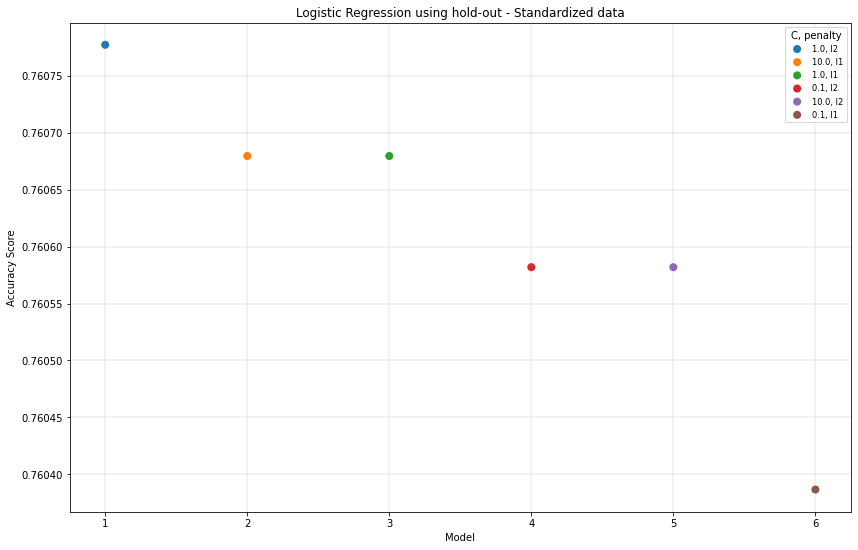

Best score: 0.760728 using {'C': 10.0, 'penalty': 'l1'}
Accuracy score in testing data: 0.7546771862672343
Model training time: 537.34s


,C,penalty,Accuracy Score,Precision,Recall,F1,Runtime
0,10.0,l1,0.760728,0.765022,0.751174,0.758035,235.895586
1,1.0,l1,0.760680,0.764946,0.751174,0.757998,244.895813
2,0.1,l1,0.760045,0.764114,0.750881,0.757440,244.711376
3,1.0,l2,0.748084,0.748575,0.745499,0.747034,28.286963
4,0.1,l2,0.741054,0.741977,0.737476,0.739719,23.448700
5,10.0,l2,0.740956,0.741831,0.737476,0.739647,22.680225


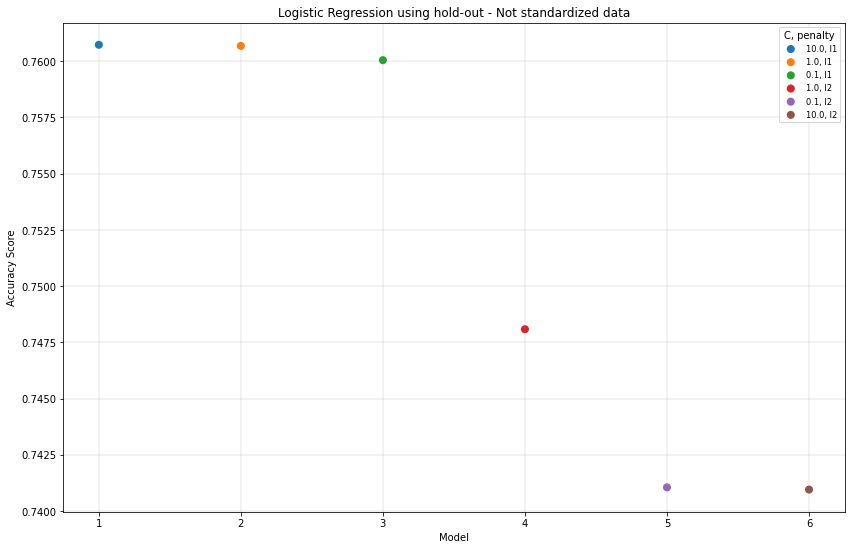

In [35]:
# Tuning algorithm - Logistic Regression Hold-out

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridLR_h = dict(penalty=np.array(["l1", "l2"]),
                         C=np.array([0.1, 1, 10]))

    modelLR_h = LogisticRegression(solver='liblinear', max_iter=1e3, random_state=randNum)
    gridLR_h = GridSearchCV(estimator=modelLR_h,
                            param_grid=paramGridLR_h,
                            cv=holdOutSplit,
                            scoring=scoring,
                            refit='accuracy',
                            n_jobs=-1)
    grid_result_LR_h = gridLR_h.fit(X_train, y_train)

    print("Best score: %f using %s" % (grid_result_LR_h.best_score_, grid_result_LR_h.best_params_))
    print("Accuracy score in testing data:", (grid_result_LR_h.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_LR_h, 'Logistic Regression using hold-out - ' + label)

Best score: 0.756657 using {'C': 1.0, 'penalty': 'l2'}
Accuracy score in testing data: 0.754716244190134
Model training time: 357.95s


,C,penalty,Accuracy Score,Precision,Recall,F1,Runtime
0,1.0,l2,0.756657,0.759881,0.748893,0.754327,3.362148
1,10.0,l2,0.756647,0.759835,0.748952,0.754335,3.387060
2,1.0,l1,0.756647,0.759854,0.748912,0.754324,56.904480
3,10.0,l1,0.756637,0.759851,0.748893,0.754313,57.567017
4,0.1,l1,0.756530,0.759957,0.748360,0.754096,15.704888
5,0.1,l2,0.756471,0.759759,0.748580,0.754108,2.832608


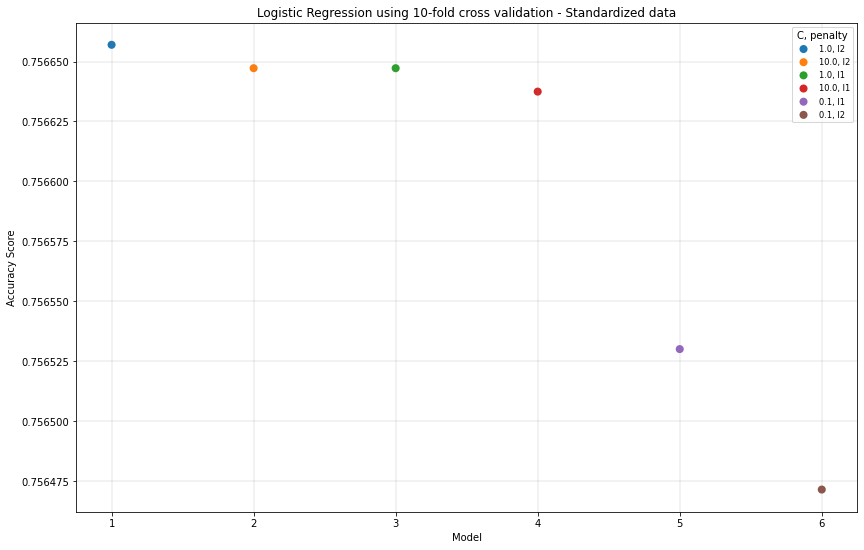

Best score: 0.756647 using {'C': 10.0, 'penalty': 'l1'}
Accuracy score in testing data: 0.7546771862672343
Model training time: 3030.75s


,C,penalty,Accuracy Score,Precision,Recall,F1,Runtime
0,10.0,l1,0.756647,0.759866,0.748893,0.754320,309.294085
1,1.0,l1,0.756618,0.759820,0.748892,0.754297,335.659052
2,0.1,l1,0.756569,0.759857,0.748677,0.754207,351.347665
3,10.0,l2,0.740448,0.741651,0.736102,0.738853,26.167275
4,0.1,l2,0.738261,0.739484,0.733868,0.736653,32.455253
5,1.0,l2,0.736971,0.738043,0.732933,0.735461,24.803949


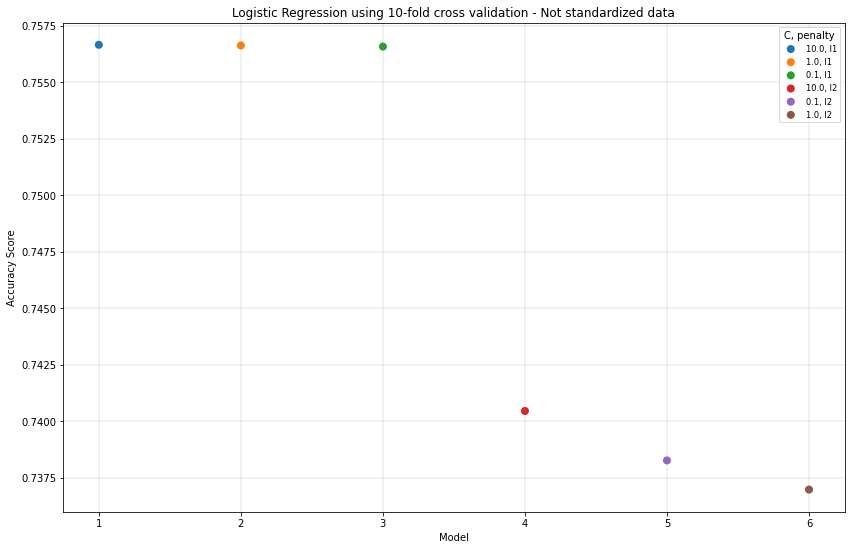

In [36]:
# Tuning algorithm - Logistic Regression 10-fold CV

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridLR_cv = dict(penalty=np.array(["l1", "l2"]),
                          C=np.array([0.1, 1, 10]))
    
    modelLR_cv = LogisticRegression(solver='liblinear', max_iter=1e3, random_state=randNum)
    gridLR_cv = GridSearchCV(estimator=modelLR_cv,
                             param_grid=paramGridLR_cv,
                             cv=kfoldSplit,
                             scoring=scoring,
                             refit='accuracy',
                             n_jobs=-1)
    grid_result_LR_cv = gridLR_cv.fit(X_train, y_train)
    
    print("Best score: %f using %s" % (grid_result_LR_cv.best_score_, grid_result_LR_cv.best_params_))
    print("Accuracy score in testing data:", (grid_result_LR_cv.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_LR_cv, 'Logistic Regression using 10-fold cross validation - ' + label)

Best score: 0.760533 using {'C': 0.1}
Accuracy score in testing data: 0.7544037808069367
Model training time: 12.23s


,C,Accuracy Score,Precision,Recall,F1,Runtime
0,1.0,0.760533,0.765246,0.750196,0.757646,3.571935
1,0.1,0.760533,0.765193,0.750294,0.757670,3.657733
2,10.0,0.760435,0.765146,0.750098,0.757547,3.548949
3,5.0,0.760435,0.765146,0.750098,0.757547,3.609254


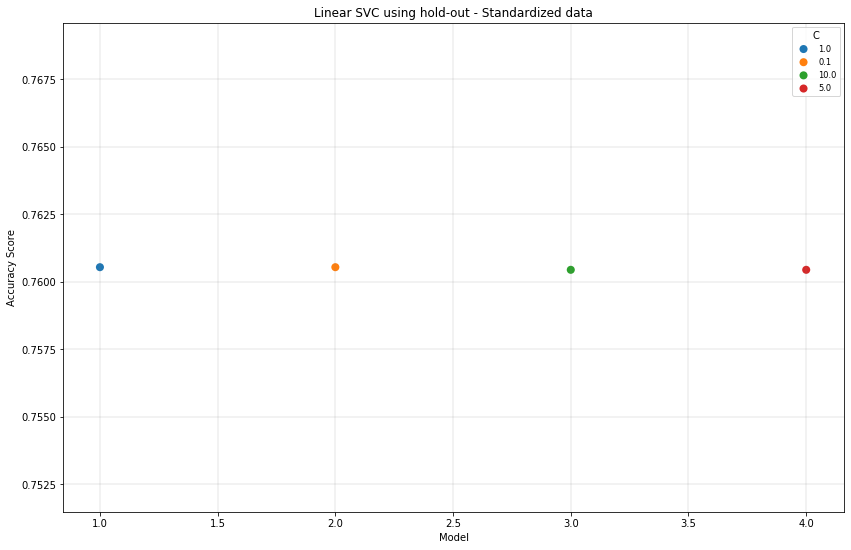

Best score: 0.756286 using {'C': 10.0}
Accuracy score in testing data: 0.7347967035113072
Model training time: 71.22s


,C,Accuracy Score,Precision,Recall,F1,Runtime
0,10.0,0.756286,0.758556,0.750391,0.754452,44.002462
1,5.0,0.755407,0.756903,0.750978,0.753929,43.993931
2,1.0,0.748865,0.748824,0.747358,0.748090,35.675965
3,0.1,0.735244,0.734618,0.734834,0.734726,41.924519


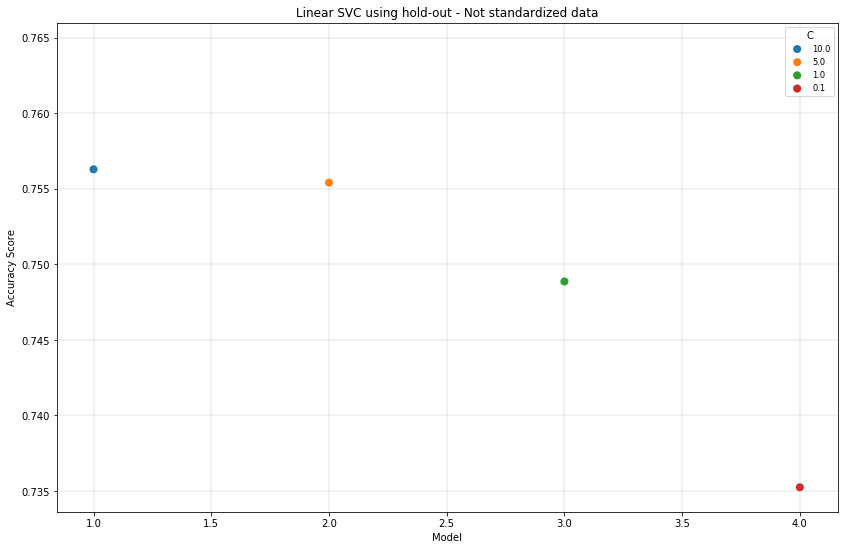

In [37]:
# Tuning algorithm - LinearSVC Hold-Out

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridLinearSVC_h = dict(C=np.array([0.1, 1, 5, 10]))
    
    modelLinearSVC_h = LinearSVC(penalty="l2", dual=False, max_iter=1e6)
    gridLinearSVC_h = GridSearchCV(estimator=modelLinearSVC_h,
                                   param_grid=paramGridLinearSVC_h,
                                   cv=holdOutSplit,
                                   scoring=scoring,
                                   refit='accuracy',
                                   n_jobs=-1)
    grid_result_LinearSVC_h = gridLinearSVC_h.fit(X_train, y_train)
    
    print("Best score: %f using %s" % (grid_result_LinearSVC_h.best_score_, grid_result_LinearSVC_h.best_params_))
    print("Accuracy score in testing data:", (grid_result_LinearSVC_h.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_LinearSVC_h, 'Linear SVC using hold-out - ' + label)

Best score: 0.757038 using {'C': 0.1}
Accuracy score in testing data: 0.7544037808069367
Model training time: 64.51s


,C,Accuracy Score,Precision,Recall,F1,Runtime
0,0.1,0.757038,0.761059,0.747775,0.754339,6.647692
1,1.0,0.757038,0.761038,0.747815,0.754349,5.934114
2,5.0,0.757018,0.761008,0.747815,0.754334,5.616173
3,10.0,0.757018,0.760997,0.747834,0.754339,5.726694


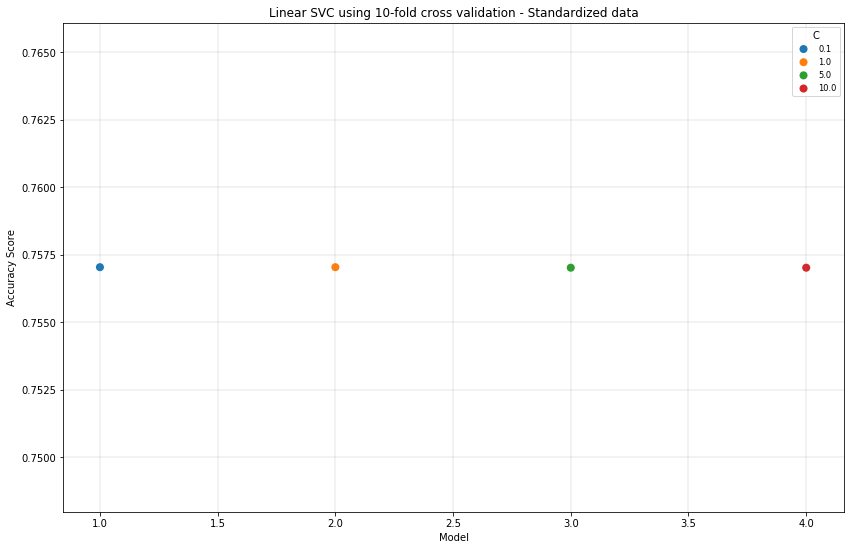

Best score: 0.738632 using {'C': 10.0}
Accuracy score in testing data: 0.7347967035113072
Model training time: 463.95s


,C,Accuracy Score,Precision,Recall,F1,Runtime
0,10.0,0.738632,0.739412,0.735334,0.737346,40.609120
1,1.0,0.737099,0.737412,0.734631,0.736001,41.464096
2,0.1,0.736894,0.737518,0.733790,0.735635,45.899735
3,5.0,0.735634,0.735558,0.733996,0.734764,42.291761


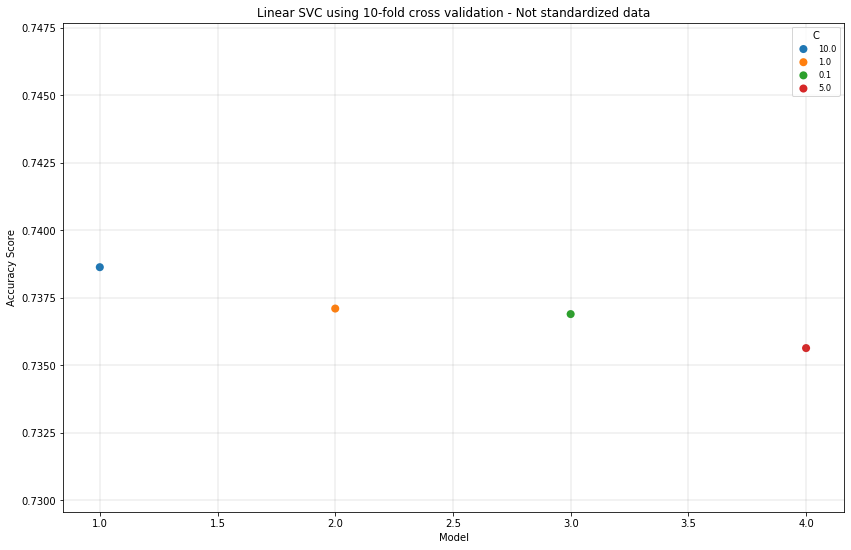

In [38]:
# Tuning algorithm - LinearSVC 10-fold CV

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridLinearSVC_cv = dict(C=np.array([0.1, 1, 5, 10]))
    
    modelLinearSVC_cv = LinearSVC(penalty="l2", dual=False, max_iter=1e6)
    gridLinearSVC_cv = GridSearchCV(estimator=modelLinearSVC_cv,
                                    param_grid=paramGridLinearSVC_cv,
                                    cv=kfoldSplit,
                                    scoring=scoring,
                                    refit='accuracy',
                                    n_jobs=-1)
    grid_result_LinearSVC_cv = gridLinearSVC_cv.fit(X_train, y_train)

    print("Best score: %f using %s" % (grid_result_LinearSVC_cv.best_score_, grid_result_LinearSVC_cv.best_params_))
    print("Accuracy score in testing data:", (grid_result_LinearSVC_cv.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_LinearSVC_cv, 'Linear SVC using 10-fold cross validation - ' + label)

Best score: 0.937216 using {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
Accuracy score in testing data: 0.9382494238956373
Model training time: 239.95s


,bootstrap,criterion,n_estimators,Accuracy Score,Precision,Recall,F1,Runtime
0,False,entropy,100,0.937216,0.970211,0.901859,0.934787,147.263961
1,False,gini,100,0.937167,0.970108,0.901859,0.934740,99.177166
2,False,entropy,50,0.935312,0.968207,0.899902,0.932806,77.186010
3,False,gini,50,0.935068,0.967895,0.899706,0.932556,54.052324
4,True,entropy,100,0.933018,0.967851,0.895499,0.930270,65.251642
5,True,entropy,50,0.932090,0.967291,0.894129,0.929272,51.102105
6,True,gini,100,0.931797,0.965201,0.895597,0.929097,66.998768
7,True,gini,50,0.929063,0.962151,0.892955,0.926262,36.192287


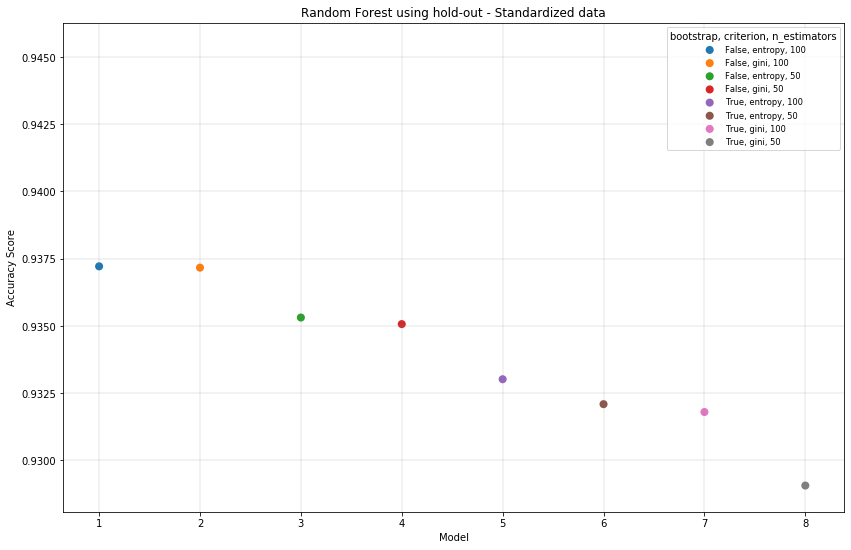

Best score: 0.937119 using {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 100}
Accuracy score in testing data: 0.9391868140452291
Model training time: 209.08s


,bootstrap,criterion,n_estimators,Accuracy Score,Precision,Recall,F1,Runtime
0,False,gini,100,0.937119,0.970105,0.901761,0.934686,95.602916
1,False,entropy,100,0.937070,0.970102,0.901663,0.934632,140.462784
2,False,entropy,50,0.935361,0.968211,0.900000,0.932860,74.732586
3,False,gini,50,0.935068,0.967993,0.899609,0.932549,52.217533
4,True,entropy,100,0.932969,0.967749,0.895499,0.930223,60.175065
5,True,entropy,50,0.932090,0.967291,0.894129,0.929272,47.139879
6,True,gini,100,0.931944,0.965408,0.895695,0.929246,62.551949
7,True,gini,50,0.929014,0.962537,0.892466,0.926178,35.153214


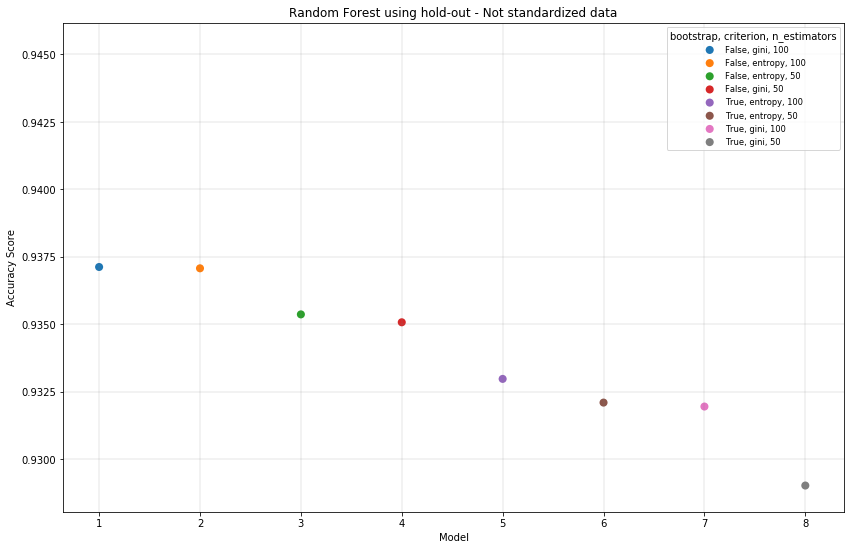

In [39]:
# Tuning algorithm - Random Forest Hold-Out

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridRF_h = dict(n_estimators=np.array([50, 100]),
                         criterion=np.array(["gini", "entropy"]),
                         bootstrap=np.array([False, True]))

    modelRF_h = RandomForestClassifier(n_jobs=-1, random_state=randNum)
    gridRF_h = GridSearchCV(estimator=modelRF_h,
                            param_grid=paramGridRF_h,
                            cv=holdOutSplit,
                            scoring=scoring,
                            refit='accuracy',
                            n_jobs=-1)
    grid_result_RF_h = gridRF_h.fit(X_train, y_train)

    print("Best score: %f using %s" % (grid_result_RF_h.best_score_, grid_result_RF_h.best_params_))
    print("Accuracy score in testing data:", (grid_result_RF_h.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_RF_h, 'Random Forest using hold-out - ' + label)

Best score: 0.937438 using {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
Accuracy score in testing data: 0.9382494238956373
Model training time: 1911.27s


,bootstrap,criterion,n_estimators,Accuracy Score,Precision,Recall,F1,Runtime
0,False,entropy,100,0.937438,0.972412,0.900152,0.934880,161.551784
1,False,gini,100,0.936560,0.970387,0.900325,0.934036,115.532055
2,False,entropy,50,0.936374,0.971413,0.898939,0.933764,81.953935
3,False,gini,50,0.935359,0.969474,0.898742,0.932763,57.013409
4,True,entropy,100,0.933747,0.970085,0.894809,0.930923,108.583062
5,True,gini,100,0.932947,0.968574,0.894631,0.930128,80.199615
6,True,entropy,50,0.931794,0.968483,0.892348,0.928852,59.700586
7,True,gini,50,0.931189,0.966767,0.892777,0.928294,40.138287


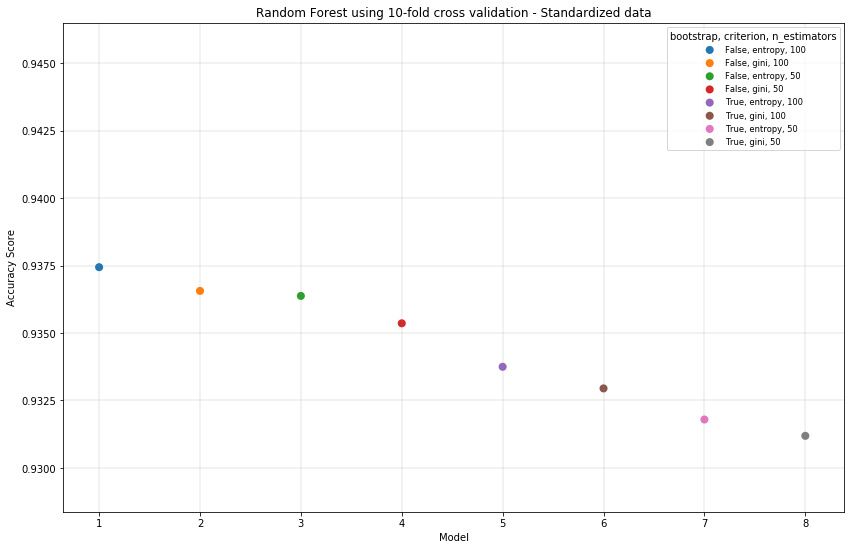

Best score: 0.937399 using {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
Accuracy score in testing data: 0.9383275397414366
Model training time: 1845.88s


,bootstrap,criterion,n_estimators,Accuracy Score,Precision,Recall,F1,Runtime
0,False,entropy,100,0.937399,0.972391,0.900092,0.934837,163.236461
1,False,gini,100,0.936579,0.970526,0.900226,0.934047,112.939141
2,False,entropy,50,0.936335,0.971451,0.898822,0.933718,82.038230
3,False,gini,50,0.935329,0.969413,0.898742,0.932735,58.038375
4,True,entropy,100,0.933767,0.970187,0.894750,0.930937,99.155634
5,True,gini,100,0.932947,0.968574,0.894633,0.930129,76.174184
6,True,entropy,50,0.931834,0.968546,0.892367,0.928891,54.897890
7,True,gini,50,0.931238,0.966772,0.892873,0.928348,38.956936


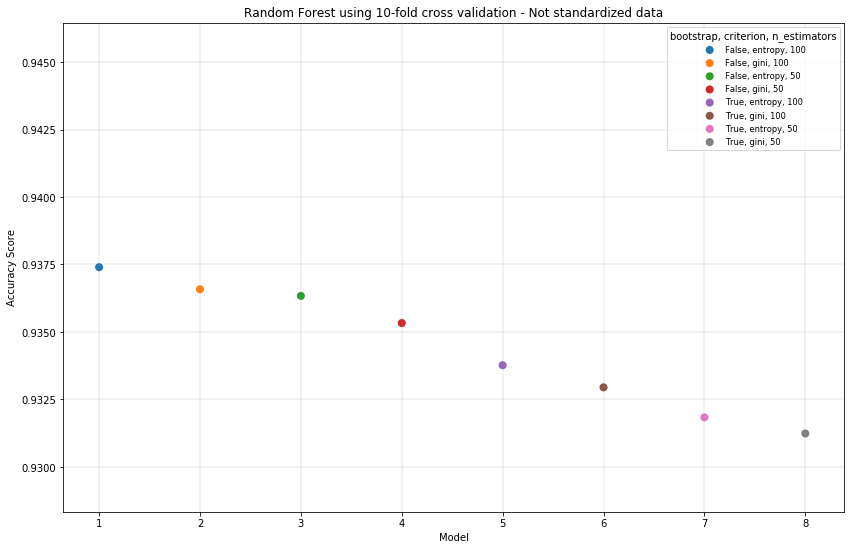

In [40]:
# Tuning algorithm - Random Forest 10-fold CV

for label, X_train, X_test, y_train, y_test in data_to_fit:
    t0 = time.time()
    paramGridRF_cv = dict(n_estimators=np.array([50, 100]),
                          criterion=np.array(["gini", "entropy"]),
                          bootstrap=np.array([False, True]))

    modelRF_cv = RandomForestClassifier(n_jobs=-1, random_state=randNum)
    gridRF_cv = GridSearchCV(estimator=modelRF_cv,
                             param_grid=paramGridRF_cv,
                             cv=kfoldSplit,
                             scoring=scoring,
                             refit='accuracy',
                             n_jobs=-1)
    grid_result_RF_cv = gridRF_cv.fit(X_train, y_train)

    print("Best score: %f using %s" % (grid_result_RF_cv.best_score_, grid_result_RF_cv.best_params_))
    print("Accuracy score in testing data:", (grid_result_RF_cv.score(X_test, y_test)))
    print ('Model training time: %.2fs' % (time.time() - t0))
    show_results(grid_result_RF_cv, 'Random Forest using 10-fold cross validation - ' + label)

### Conclusion

From the tests above we can see that `RandomForestClassifier` scored the highest on the test data (`93.92` using holdout method and `93.83` using 10-fold cross-validation method), and it is not affected by standardization because it scored nearly the same in both of the cases. 
The other two classifiers, Logistic Regression and Linear SVC, took a lot of time to fit the data when using non standardized compared to standardized data.